In [78]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, f1_score, RocCurveDisplay, accuracy_score

In [360]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Initial Data

In [2]:
data = pd.read_csv(r"E:\DS\CAPSTONE3\data_travel_insurance.csv")
data.head(5)

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [4]:
data["Gender"].fillna("Unknown", inplace=True)
print(data["Gender"].value_counts())

Gender
Unknown    31647
M           6504
F           6177
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_23320\2319859756.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Gender"].fillna("Unknown", inplace=True)


In [5]:
# Terlalu banyak data kosong di kolom Gender jadi sebaiknya dihapus saja
# Nama agensi tidak diperlukan
newdata = data.drop(["Agency","Gender"],axis='columns')
newdata.head(5)

,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No
1,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,No
2,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,No
3,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,No
4,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,No


In [6]:
# Value counts
for i in newdata.columns:
    print(newdata[i].value_counts())
    print('')

Agency Type
Travel Agency    32113
Airlines         12215
Name: count, dtype: int64

Distribution Channel
Online     43572
Offline      756
Name: count, dtype: int64

Product Name
Cancellation Plan                       12979
2 way Comprehensive Plan                 9341
Rental Vehicle Excess Insurance          5980
Basic Plan                               3834
Bronze Plan                              2847
1 way Comprehensive Plan                 2336
Value Plan                               1907
Silver Plan                              1552
Annual Silver Plan                        975
Ticket Protector                          765
Travel Cruise Protect                     353
Comprehensive Plan                        253
Gold Plan                                 237
24 Protect                                172
Annual Gold Plan                          142
Single Trip Travel Protect Gold           135
Premier Plan                              130
Single Trip Travel Protect Silver     

In [7]:
newdata.describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


## Data Preprocessing

In [8]:
# Memperkecil banyaknya kategori data Destination dengan menggabungkan kategori bervalue rendah ke dalam 1 kategori Others
dest = newdata["Destination"].value_counts()
destdf = pd.DataFrame(dest).reset_index()
destmean = destdf["count"].mean()
destmean

np.float64(321.2173913043478)

In [9]:
newdata["Destination"] = newdata["Destination"].apply(lambda x: "Others" if dest[x]<destmean else x)
newdata["Destination"].value_counts()

Destination
SINGAPORE                    9267
MALAYSIA                     4139
THAILAND                     4122
Others                       3724
CHINA                        3396
AUSTRALIA                    2578
INDONESIA                    2384
PHILIPPINES                  1758
UNITED STATES                1743
HONG KONG                    1743
INDIA                        1572
JAPAN                        1451
VIET NAM                     1194
KOREA, REPUBLIC OF           1030
UNITED KINGDOM                906
TAIWAN, PROVINCE OF CHINA     758
MYANMAR                       585
BRUNEI DARUSSALAM             550
NEW ZEALAND                   372
CANADA                        371
CAMBODIA                      344
FRANCE                        341
Name: count, dtype: int64

In [10]:
# Memperkecil banyaknya kategori data Product Name dengan menggabungkan kategori bervalue rendah ke dalam 1 kategori Others
prodn = newdata["Product Name"].value_counts()
prodndf = pd.DataFrame(prodn).reset_index()
prodnmean = prodndf["count"].mean()
prodnmean

np.float64(1704.923076923077)

In [11]:
newdata["Product Name"] = newdata["Product Name"].apply(lambda x: "others" if prodn[x]<prodnmean else x)
newdata["Product Name"].value_counts()

Product Name
Cancellation Plan                  12979
2 way Comprehensive Plan            9341
Rental Vehicle Excess Insurance     5980
others                              5104
Basic Plan                          3834
Bronze Plan                         2847
1 way Comprehensive Plan            2336
Value Plan                          1907
Name: count, dtype: int64

In [12]:
# Ubah seluruh data ke lowercase agar mempermudah pemodelan
for i in newdata.select_dtypes(include=['object']).columns:
    newdata[i] = newdata[i].apply(str.lower)

In [13]:
newdata.head()

,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,airlines,online,others,365,singapore,216.0,54.0,57,no
1,travel agency,online,cancellation plan,4,malaysia,10.0,0.0,33,no
2,airlines,online,basic plan,19,india,22.0,7.7,26,no
3,travel agency,online,2 way comprehensive plan,20,united states,112.0,0.0,59,no
4,airlines,online,bronze plan,8,singapore,16.0,4.0,28,no


<Figure size 1000x400 with 0 Axes>

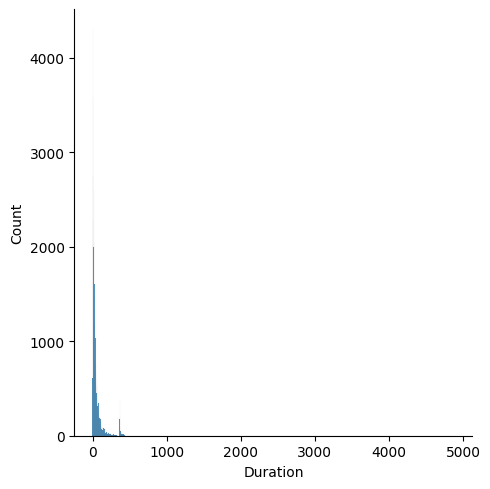

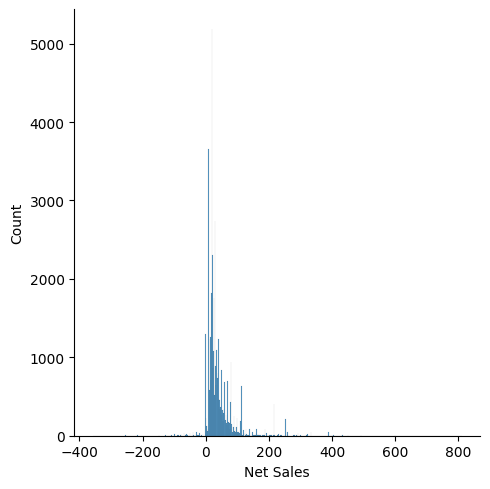

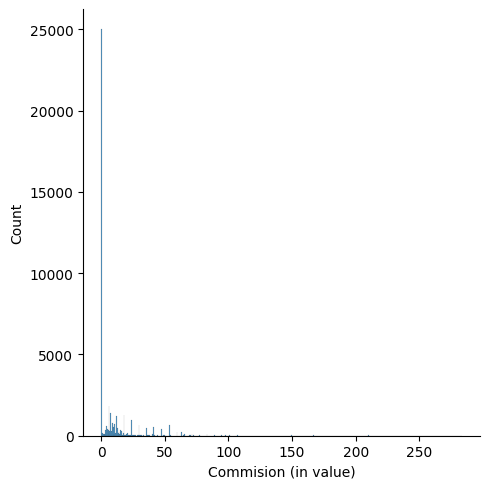

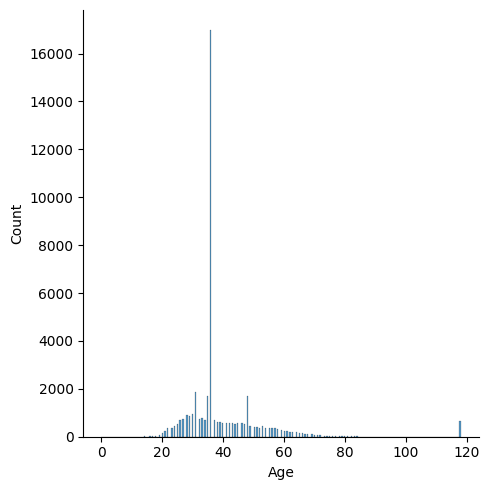

In [14]:
# Persebaran data numerik
plt.figure(figsize = (10,4))
sns.displot(newdata['Duration'])
sns.displot(newdata['Net Sales'])
sns.displot(newdata['Commision (in value)'])
sns.displot(newdata['Age'])
plt.tight_layout()

<Axes: >

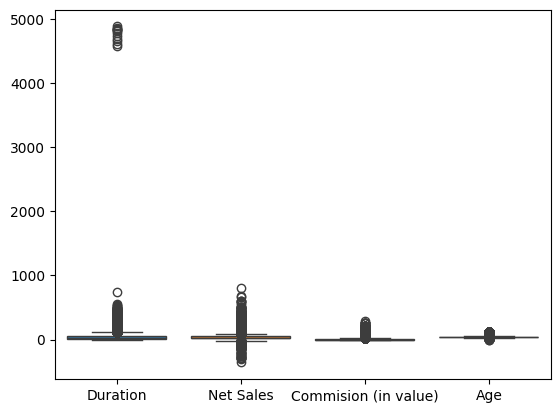

In [15]:
# Boxplot
sns.boxplot(newdata)

In [16]:
newdata.describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [17]:
# Lihat Duration di atas 4000
# Hapus Duration di bawah 1

newdata= newdata[newdata["Duration"]>0]

data[data["Duration"]>4000]

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
87,SSI,Airlines,Online,Ticket Protector,Unknown,4736,SINGAPORE,0.32,0.09,48,No
4678,SSI,Airlines,Online,Ticket Protector,Unknown,4857,SINGAPORE,0.32,0.09,48,No
10172,SSI,Airlines,Online,Ticket Protector,Unknown,4815,SINGAPORE,0.32,0.09,48,No
12140,SSI,Airlines,Online,Ticket Protector,Unknown,4652,SINGAPORE,0.32,0.09,48,No
19497,SSI,Airlines,Online,Ticket Protector,Unknown,4881,SINGAPORE,0.13,0.04,48,No
20038,SSI,Airlines,Online,Ticket Protector,Unknown,4844,SINGAPORE,0.32,0.09,48,No
22215,SSI,Airlines,Online,Ticket Protector,Unknown,4580,SINGAPORE,0.32,0.09,48,No
25606,SSI,Airlines,Online,Ticket Protector,Unknown,4685,SINGAPORE,0.32,0.09,48,No
28032,SSI,Airlines,Online,Ticket Protector,Unknown,4829,SINGAPORE,0.32,0.09,48,No
37207,SSI,Airlines,Online,Ticket Protector,Unknown,4609,SINGAPORE,0.32,0.09,48,No


<Axes: ylabel='Duration'>

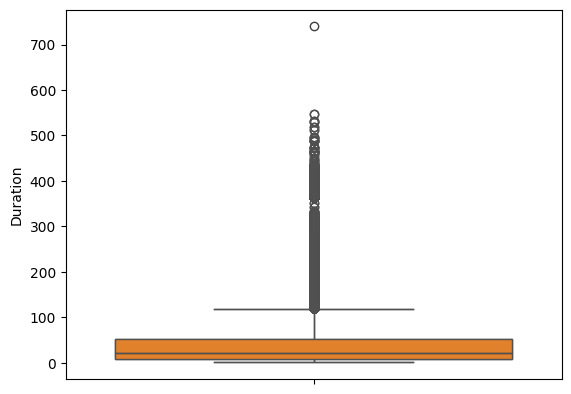

In [18]:
# Data di atas cukup mencurigakan karena 8 dari 11 kolom bernilai sama semua dan outlier terlalu jauh dari data di kolom Duration lainnya
# Sebaiknya data dihapus

newdata = newdata[newdata["Duration"]<4000]
sns.boxplot(newdata["Duration"])
#Outlier cukup banyak sehingga sebaiknya dibiarkan saja (kecuali outlier di atas 700)
newdata = newdata[newdata["Duration"]<700]
sns.boxplot(newdata["Duration"])

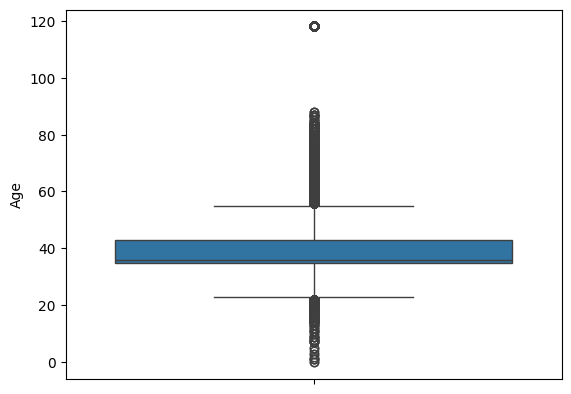

In [19]:
sns.boxplot(newdata["Age"])
# Hapus outlier umur di atas 100 tahun
newdata = newdata[newdata["Age"]<100]

<Axes: ylabel='Age'>

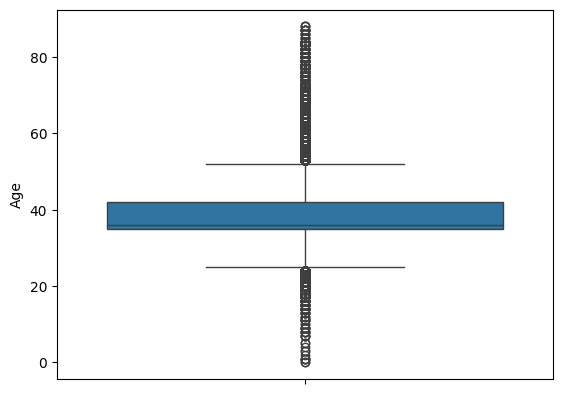

In [20]:
sns.boxplot(newdata["Age"])
# Outlier cukup banyak sehingga sebaiknya dibiarkan saja

<Axes: ylabel='Net Sales'>

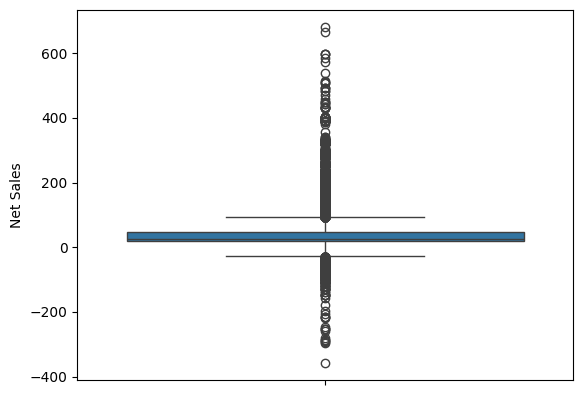

In [21]:
sns.boxplot(newdata["Net Sales"])

<Axes: ylabel='Commision (in value)'>

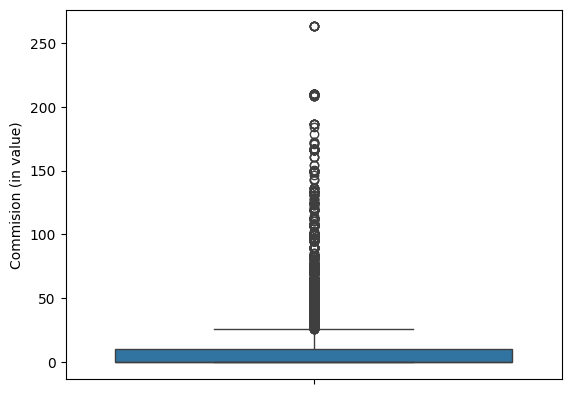

In [22]:
sns.boxplot(newdata["Commision (in value)"])

In [23]:
newdata[newdata["Commision (in value)"]>200]
# Data cukup beragam sehingga sebaiknya dibiarkan saja

,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
3658,travel agency,online,others,397,united states,320.00,208.00,44,yes
4101,travel agency,online,others,389,united states,323.40,210.21,38,no
6726,travel agency,online,others,366,united states,323.40,210.21,47,no
7018,travel agency,online,others,382,united states,323.40,210.21,36,no
7636,travel agency,online,others,364,united states,323.40,210.21,42,no
7820,travel agency,online,others,367,united states,320.25,208.16,55,no
7889,travel agency,online,others,365,united states,323.40,210.21,40,no
8639,travel agency,online,others,380,united states,323.40,210.21,62,no
9302,travel agency,online,others,381,united states,323.40,210.21,41,no
10325,travel agency,online,others,365,united states,404.25,262.76,58,no


In [24]:
# Scaling data dengan robust scaler karena banyak outlier
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()

In [25]:
newdata_robust = robust.fit_transform(newdata[['Duration','Net Sales','Commision (in value)','Age']])
newdata_robust = pd.DataFrame(newdata_robust, columns=['Duration','Net Sales','Commision (in value)','Age'])
newdata_robust

,Duration,Net Sales,Commision (in value),Age
0,7.976744,6.333333,5.142857,3.000000
1,-0.418605,-0.533333,0.000000,-0.428571
2,-0.069767,-0.133333,0.733333,-1.428571
3,-0.046512,2.866667,0.000000,3.285714
4,-0.325581,-0.333333,0.380952,-1.142857
...,...,...,...,...
43604,-0.186047,0.133333,0.000000,0.000000
43605,-0.116279,1.773333,4.525714,1.571429
43606,0.976744,0.133333,1.000000,2.000000
43607,0.674419,0.333333,0.000000,0.000000


In [26]:
newdata_robust.describe()

,Duration,Net Sales,Commision (in value),Age
count,43609.000000,43609.000000,43609.000000,43609.000000
mean,0.612741,0.481275,0.910742,0.387459
std,1.715175,1.622020,1.868159,1.441894
min,-0.488372,-12.783333,0.000000,-5.142857
25%,-0.279070,-0.266667,0.000000,-0.142857
50%,0.000000,0.000000,0.000000,0.000000
75%,0.720930,0.733333,1.000000,0.857143
max,12.209302,21.866667,25.024762,7.428571


<Axes: >

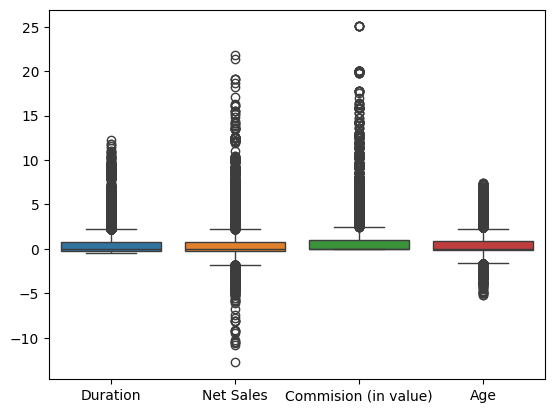

In [27]:
sns.boxplot(newdata_robust)
# Sudah baik

In [28]:
# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [29]:
newdata["Claim"].value_counts()

Claim
no     42939
yes      670
Name: count, dtype: int64

In [30]:
# Ubah Claim menjadi 0 jika no dan 1 jika yes
copydata = newdata["Claim"]
copydata = copydata.apply(lambda x: 0 if x=="no" else (1 if x=="yes" else None))
newdata["Claim"] = copydata
newdata["Claim"].value_counts()

Claim
0    42939
1      670
Name: count, dtype: int64

In [31]:
transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = None),['Agency Type','Distribution Channel','Product Name','Destination']),
                                 ('robust scaler',RobustScaler(),['Duration','Net Sales','Commision (in value)','Age'])
                                ], remainder = 'passthrough')

In [32]:
# Data Splitting
feature = ['Agency Type','Distribution Channel','Product Name','Destination','Duration','Net Sales','Commision (in value)','Age']
X = newdata[feature]
y = newdata["Claim"]

In [33]:
# EDA
newdata["Claim"].value_counts()/newdata.shape[0]*100

Claim
0    98.46362
1     1.53638
Name: count, dtype: float64

In [34]:
#Split data ke 75% train dan 25% validation dan stratify karena class imbalance
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 42, test_size=0.25, stratify = y)

In [35]:
# Transform data
X_train_preprocessed = transformer.fit_transform(X_train) # .fit and .transform method
X_val_preprocessed = transformer.transform(X_val) #.transform method

In [36]:
X_train_preprocessed = pd.DataFrame.sparse.from_spmatrix(X_train_preprocessed)
X_val_preprocessed = pd.DataFrame.sparse.from_spmatrix(X_val_preprocessed)

In [37]:
X_train.head()

,Agency Type,Distribution Channel,Product Name,Destination,Duration,Net Sales,Commision (in value),Age
23269,airlines,online,others,singapore,15,62.0,15.5,60
1192,travel agency,online,2 way comprehensive plan,viet nam,5,27.0,0.0,36
31190,airlines,online,basic plan,thailand,75,22.0,7.7,36
39272,travel agency,online,cancellation plan,singapore,44,80.0,0.0,36
30049,travel agency,online,cancellation plan,malaysia,5,10.0,0.0,36


In [38]:
X_train_preprocessed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,1.0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,-0.162791,1.2,1.47619,3.428571
1,0,1.0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,-0.395349,0.033333,0,0
2,1.0,0,0,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,1.232558,-0.133333,0.733333,0
3,0,1.0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0.511628,1.8,0,0
4,0,1.0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,-0.395349,-0.533333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32701,0,1.0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,-0.302326,-0.2,0,0
32702,1.0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0.27907,-0.333333,0.380952,4.285714
32703,1.0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,-0.626667,0.192381,1.714286
32704,0,1.0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,-0.232558,0.066667,0,0


In [39]:
transformer.transformers_

[('one hot encoder',
  OneHotEncoder(),
  ['Agency Type', 'Distribution Channel', 'Product Name', 'Destination']),
 ('robust scaler',
  RobustScaler(),
  ['Duration', 'Net Sales', 'Commision (in value)', 'Age'])]

In [40]:
transformer.transformers_[0][1].get_feature_names_out()

array(['Agency Type_airlines', 'Agency Type_travel agency',
       'Distribution Channel_offline', 'Distribution Channel_online',
       'Product Name_1 way comprehensive plan',
       'Product Name_2 way comprehensive plan', 'Product Name_basic plan',
       'Product Name_bronze plan', 'Product Name_cancellation plan',
       'Product Name_others',
       'Product Name_rental vehicle excess insurance',
       'Product Name_value plan', 'Destination_australia',
       'Destination_brunei darussalam', 'Destination_cambodia',
       'Destination_canada', 'Destination_china', 'Destination_france',
       'Destination_hong kong', 'Destination_india',
       'Destination_indonesia', 'Destination_japan',
       'Destination_korea, republic of', 'Destination_malaysia',
       'Destination_myanmar', 'Destination_new zealand',
       'Destination_others', 'Destination_philippines',
       'Destination_singapore', 'Destination_taiwan, province of china',
       'Destination_thailand', 'Destinati

In [41]:
features = list(transformer.transformers_[0][1].get_feature_names_out()) + ['Duration_scaled', 'Net Sales_scaled', 'Commision (in value)_scaled', 'Age_scaled']
X_train_preprocessed.columns = features
X_val_preprocessed.columns = features
X_train_preprocessed

,Agency Type_airlines,Agency Type_travel agency,Distribution Channel_offline,Distribution Channel_online,Product Name_1 way comprehensive plan,Product Name_2 way comprehensive plan,Product Name_basic plan,Product Name_bronze plan,Product Name_cancellation plan,Product Name_others,Product Name_rental vehicle excess insurance,Product Name_value plan,Destination_australia,Destination_brunei darussalam,Destination_cambodia,Destination_canada,Destination_china,Destination_france,Destination_hong kong,Destination_india,Destination_indonesia,Destination_japan,"Destination_korea, republic of",Destination_malaysia,Destination_myanmar,Destination_new zealand,Destination_others,Destination_philippines,Destination_singapore,"Destination_taiwan, province of china",Destination_thailand,Destination_united kingdom,Destination_united states,Destination_viet nam,Duration_scaled,Net Sales_scaled,Commision (in value)_scaled,Age_scaled
0,1.0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,-0.162791,1.2,1.47619,3.428571
1,0,1.0,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,-0.395349,0.033333,0,0
2,1.0,0,0,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,1.232558,-0.133333,0.733333,0
3,0,1.0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0.511628,1.8,0,0
4,0,1.0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,-0.395349,-0.533333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32701,0,1.0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,-0.302326,-0.2,0,0
32702,1.0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0.27907,-0.333333,0.380952,4.285714
32703,1.0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,-0.626667,0.192381,1.714286
32704,0,1.0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,-0.232558,0.066667,0,0


## Modelling: Classification

In [42]:
import statsmodels.api as sm

In [43]:
y_train= y_train.reset_index(drop=True)
X_train_preprocessed = X_train_preprocessed.reset_index(drop=True)

In [44]:
sm_logit = sm.Logit(y_train,sm.add_constant(X_train_preprocessed))
result = sm_logit.fit(method='bfgs')

         Current function value: 0.068315
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
c:\Python310\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  Claim   No. Observations:                32706
Model:                          Logit   Df Residuals:                    32668
Method:                           MLE   Df Model:                           37
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                  0.1389
Time:                        17:27:13   Log-Likelihood:                -2234.3
converged:                      False   LL-Null:                       -2594.8
Covariance Type:            nonrobust   LLR p-value:                1.049e-127
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           -1.8728        nan        nan        nan         nan         nan
Agency Type_airlines         

In [46]:
# Logit tidak konvergen dan tidak bisa mengecek p-value tiap fitur

In [47]:
# Logistic Regression karena hanya terdiri dari 2 kelas: no dan yes
# 0: no
# 1: yes

logreg = LogisticRegression(random_state=42)

In [48]:
# EDA
newdata["Claim"].value_counts()/newdata.shape[0]*100

Claim
0    98.46362
1     1.53638
Name: count, dtype: float64

Persebaran kelas tidak seimbang

In [49]:
weights = {0:1,1:100}
logreg_balanced = LogisticRegression(class_weight=weights, random_state=42)

In [50]:
# No treatment
logreg.fit(X_train_preprocessed,y_train)
y_pred = logreg.predict(X_val_preprocessed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10735
           1       0.00      0.00      0.00       168

    accuracy                           0.98     10903
   macro avg       0.49      0.50      0.50     10903
weighted avg       0.97      0.98      0.98     10903



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 23.52222222222222, 'Predicted label')

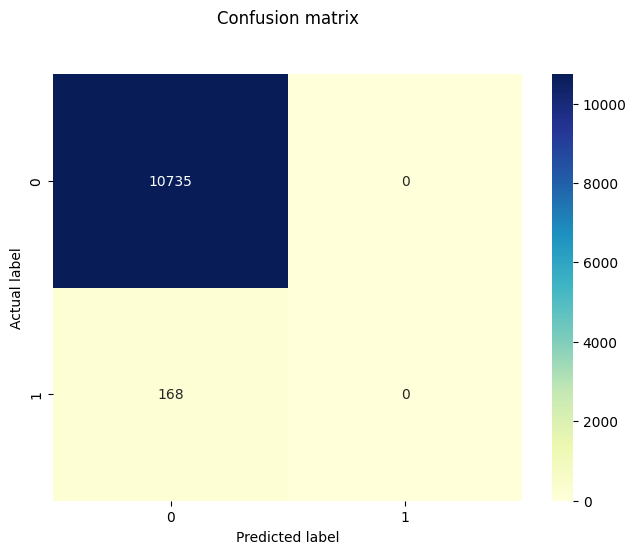

In [51]:
cnf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [52]:
# weighted logreg
logreg_balanced.fit(X_train_preprocessed,y_train)
y_pred = logreg.predict(X_val_preprocessed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10735
           1       0.00      0.00      0.00       168

    accuracy                           0.98     10903
   macro avg       0.49      0.50      0.50     10903
weighted avg       0.97      0.98      0.98     10903



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 23.52222222222222, 'Predicted label')

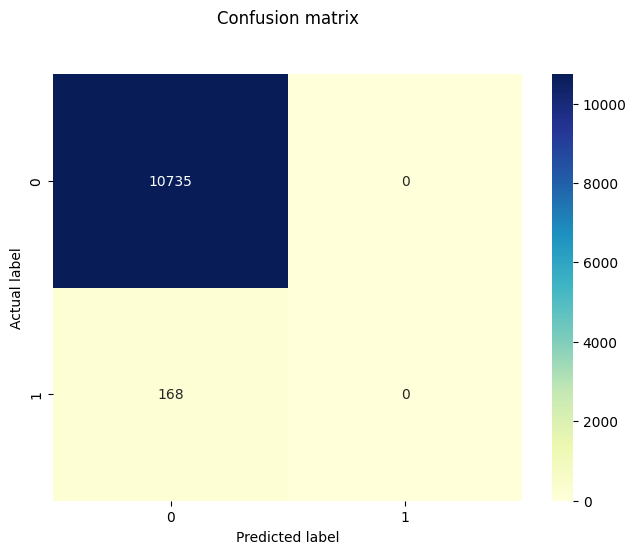

In [53]:
cnf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [54]:
# Treshold optimization
logreg.fit(X_train_preprocessed, y_train)

th_value = [i/100 for i in range(20,60)]
score = 0
score_list = []

for i in th_value:
  y_prob = logreg.predict_proba(X_val_preprocessed)[:,1]
  y_pred = np.where(y_prob>i,1,0)
  score_temp = f1_score(y_val, y_pred)
  score_list.append(score_temp)

  if score_temp > score :
    score = score_temp
    
    best_score = score
    best_th = i

<Axes: >

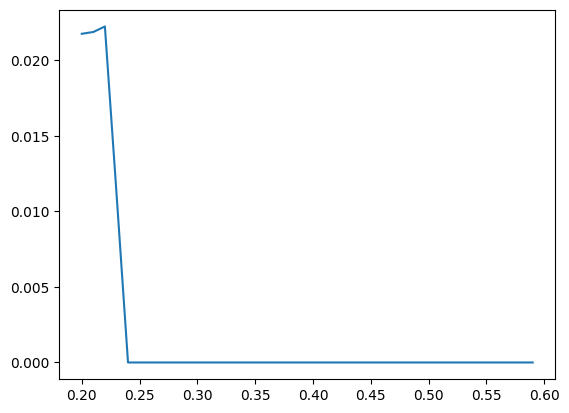

In [55]:
sns.lineplot(x=th_value, y=score_list)

In [56]:
print('best threshold', best_th)
print('best score', best_score)

best threshold 0.22
best score 0.022222222222222223


In [57]:
logreg.fit(X_train_preprocessed, y_train)
y_prob = logreg.predict_proba(X_val_preprocessed)[:,1]
y_pred = np.where(y_prob>best_th,1,0)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10735
           1       0.17      0.01      0.02       168

    accuracy                           0.98     10903
   macro avg       0.58      0.51      0.51     10903
weighted avg       0.97      0.98      0.98     10903



Text(0.5, 23.52222222222222, 'Predicted label')

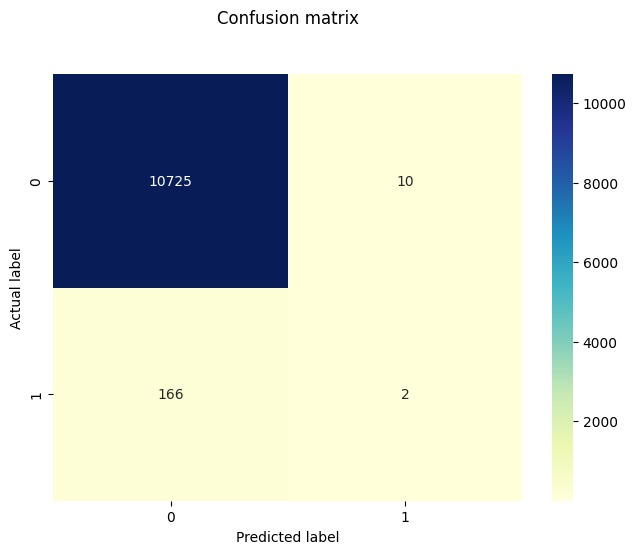

In [58]:
cnf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [59]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [60]:
# Resampling
rus = RandomUnderSampler()
ros = RandomOverSampler()

X_under, y_under = rus.fit_resample(X_train_preprocessed, y_train) # undersampling the training set
X_over, y_over = ros.fit_resample(X_train_preprocessed, y_train) # oversampling the training set

In [61]:
model_under = LogisticRegression()
model_under.fit(X_under, y_under)
y_pred = model_under.predict(X_val_preprocessed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     10735
           1       0.05      0.79      0.09       168

    accuracy                           0.74     10903
   macro avg       0.52      0.76      0.47     10903
weighted avg       0.98      0.74      0.84     10903



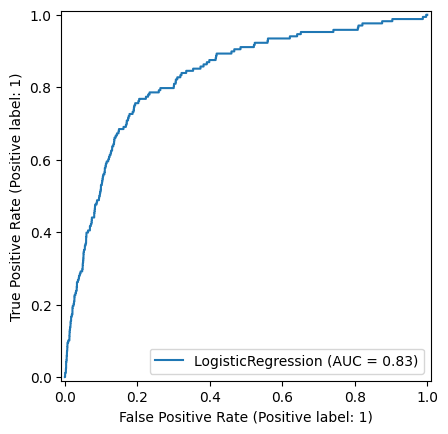

In [62]:
RocCurveDisplay.from_estimator(model_under, X_val_preprocessed, y_val)

In [63]:
model_over = LogisticRegression(solver='lbfgs', max_iter=1000)
model_over.fit(X_over, y_over)
y_pred = model_over.predict(X_val_preprocessed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     10735
           1       0.05      0.78      0.09       168

    accuracy                           0.77     10903
   macro avg       0.52      0.78      0.48     10903
weighted avg       0.98      0.77      0.86     10903



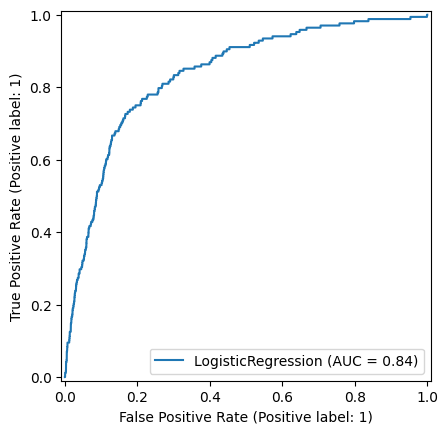

In [64]:
RocCurveDisplay.from_estimator(model_over, X_val_preprocessed, y_val)

In [96]:
# SMOTE
smote = SMOTE(sampling_strategy='minority')
model = LogisticRegression(solver='lbfgs', max_iter=1000)

X_smote, y_smote = smote.fit_resample(X_train_preprocessed, y_train)
y_smote.value_counts()

Claim
0    32204
1    32204
Name: count, dtype: int64

In [97]:
model.fit(X_smote,y_smote)
y_pred = model.predict(X_val_preprocessed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86     10735
           1       0.05      0.77      0.09       168

    accuracy                           0.76     10903
   macro avg       0.52      0.76      0.47     10903
weighted avg       0.98      0.76      0.85     10903



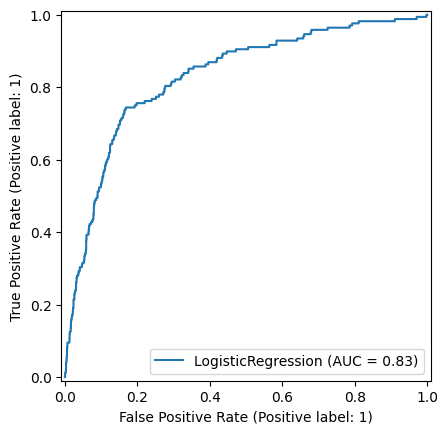

In [98]:
RocCurveDisplay.from_estimator(model, X_val_preprocessed, y_val)

In [67]:
# Near miss
nm = NearMiss()

X_nm, y_nm = nm.fit_resample(X_train_preprocessed, y_train)
y_nm.value_counts()

Claim
0    502
1    502
Name: count, dtype: int64

In [68]:
model.fit(X_nm,y_nm)
y_pred = model.predict(X_val_preprocessed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.10      0.17     10735
           1       0.01      0.70      0.02       168

    accuracy                           0.10     10903
   macro avg       0.48      0.40      0.10     10903
weighted avg       0.94      0.10      0.17     10903



In [69]:
# Voting Classifier
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth = 5)
knn = KNeighborsClassifier(n_neighbors = 3)

In [70]:
for clfs, clf_name in zip([lr,dt,knn],['Logistic Regression','Decision Tree','KNN']):
  clfs.fit(X_train_preprocessed, y_train)
  y_pred = clfs.predict(X_val_preprocessed)
  print(clf_name+":")
  print(classification_report(y_val,y_pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10735
           1       0.00      0.00      0.00       168

    accuracy                           0.98     10903
   macro avg       0.49      0.50      0.50     10903
weighted avg       0.97      0.98      0.98     10903

Decision Tree:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10735
           1       0.00      0.00      0.00       168

    accuracy                           0.98     10903
   macro avg       0.49      0.50      0.50     10903
weighted avg       0.97      0.98      0.98     10903



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: Unde

KNN:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10735
           1       0.08      0.01      0.02       168

    accuracy                           0.98     10903
   macro avg       0.53      0.50      0.51     10903
weighted avg       0.97      0.98      0.98     10903



In [73]:
# KNN
k = [1,2,3,4,5]
testing_accuracies = []
training_accuracies = []
score = 0

for i in k:
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_train_preprocessed,y_train)

  y_predict_train = knn.predict(X_train_preprocessed)
  training_accuracies.append(accuracy_score(y_train,y_predict_train))

  y_predict_test = knn.predict(X_val_preprocessed)
  acc_score = accuracy_score(y_val,y_predict_test)
  testing_accuracies.append(acc_score)

  if score < acc_score:
    score = acc_score
    best_k = i

([<matplotlib.axis.XTick at 0x1ec98af8d00>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

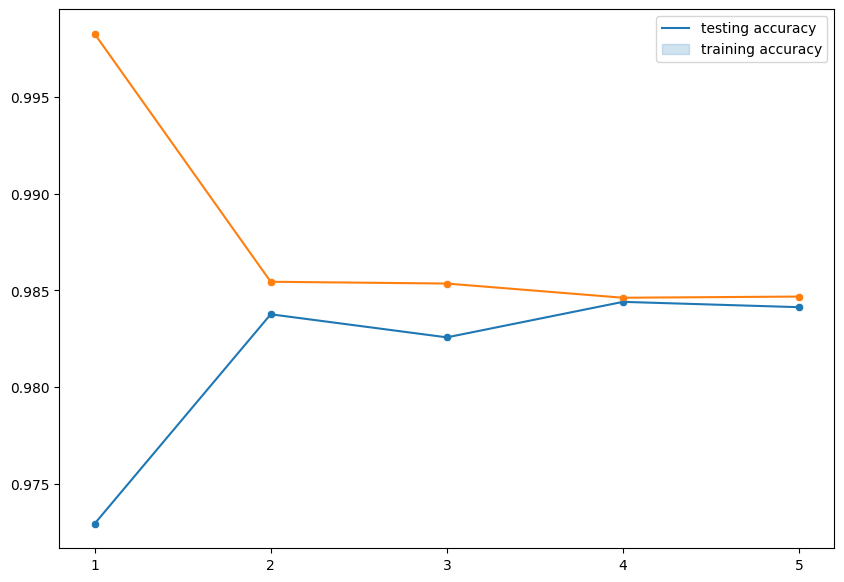

In [74]:
plt.figure(figsize = (10,7))
sns.lineplot(x = k,y = testing_accuracies)
sns.scatterplot(x = k,y = testing_accuracies)
sns.lineplot(x = k,y = training_accuracies)
sns.scatterplot(x = k,y = training_accuracies)
plt.legend(['testing accuracy','training accuracy'])
plt.xticks(list(k))

In [75]:
print('best k:', best_k)
print('accuracy:', score)

best k: 4
accuracy: 0.9844079611116207


In [76]:
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train_preprocessed, y_train)
y_pred = knn.predict(X_val_preprocessed)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10735
           1       0.00      0.00      0.00       168

    accuracy                           0.98     10903
   macro avg       0.49      0.50      0.50     10903
weighted avg       0.97      0.98      0.98     10903



In [77]:
from imblearn.pipeline import Pipeline

In [108]:
# Kombinasi cross validation dengan balancing method
modelsmote = LogisticRegression(solver='lbfgs', max_iter=1000)

estimator = Pipeline([('balancing',smote),('clf',modelsmote)])

In [110]:
skf = StratifiedKFold(n_splits = 5)
model_cv = cross_val_score(modelsmote, X_smote, y_smote, cv = skf, scoring = 'f1')

In [111]:
print('cv score :', model_cv)
print('cv score mean :', model_cv.mean())

cv score : [0.77167897 0.77328647 0.76901713 0.76820889 0.77388486]
cv score mean : 0.771215261378104


In [94]:
modelbl =  LogisticRegression(class_weight = weights, solver='lbfgs', max_iter=1000) 
model_cv = cross_val_score(modelbl, X_train_preprocessed, y_train, cv = skf, scoring = 'f1')

In [95]:
print('cv score :', model_cv)
print('cv score mean :', model_cv.mean())

cv score : [0.06818182 0.06640793 0.07442666 0.07042851 0.07391304]
cv score mean : 0.07067159241221464


In [103]:
# oversampling
model_cv = cross_val_score(model_over, X_over, y_over, cv = skf, scoring = 'f1')

In [104]:
print('cv score :', model_cv)
print('cv score mean :', model_cv.mean())

cv score : [0.76625795 0.76150235 0.76673144 0.76510275 0.76460427]
cv score mean : 0.7648397536090734


In [89]:
# Hyperparameter
# hyperparameter space
hyperparam_space = {
    'balancing__k_neighbors':[2,5,10,15,20],
    'clf__C':[100, 10, 1, 0.1, 0.01, 0.001],
    'clf__solver':['liblinear','newton-cg']
}

# stratified cross vaidation
skf = StratifiedKFold(n_splits = 5)

# hyperparameter tuning
grid_search = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'f1', # metrics
    n_jobs = -1 # use all cores
)

In [90]:
grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('balancing',
                                        SMOTE(sampling_strategy='minority')),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'balancing__k_neighbors': [2, 5, 10, 15, 20],
                         'clf__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'clf__solver': ['liblinear', 'newton-cg']},
             scoring='f1')

In [91]:
print('best score',grid_search.best_score_)
print('best param',grid_search.best_params_)

best score 0.09694772456867343
best param {'balancing__k_neighbors': 20, 'clf__C': 0.001, 'clf__solver': 'newton-cg'}


Hasil C sangat kecil, tidak signifikan

KNN menghabiskan terlalu banyak waktu

## Model Evaluation

In [175]:
# EDA
newdata["Claim"].value_counts()/newdata.shape[0]*100

Claim
0    98.46362
1     1.53638
Name: count, dtype: float64

Karena class imbalance sangat besar antara kelas "no" dan kelas "yes" (98.5:1.5), maka evaluasi melalui metrik precision kurang tepat digunakan karena precision untuk kelas kecil "yes" pasti akan sangat kecil (mendekati 0). Oleh karena itu, metrik evaluasi akan berfokus pada metrik recall untuk mengetahui berapa persen prediksi benar dari keseluruhan kelas.

Beberapa model memiliki akurasi tinggi (99%) namun nilai recall untuk kelas "yes" adalah 0. Artinya, model tidak dapat memprediksi dengan baik orang-orang yang akan mengajukan klaim. Dari semua metode untuk mengatasi class imbalance, metode SMOTE memberikan hasil paling baik (dilihat dari hasil cross validation).

In [169]:
# SMOTE untuk logres (model 1)
smote = SMOTE(sampling_strategy='minority')
model1 = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=100)

X_smote, y_smote = smote.fit_resample(X_train_preprocessed, y_train)
model1.fit(X_smote,y_smote)
y_pred = model1.predict(X_val_preprocessed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86     10735
           1       0.05      0.77      0.09       168

    accuracy                           0.76     10903
   macro avg       0.52      0.76      0.47     10903
weighted avg       0.98      0.76      0.85     10903



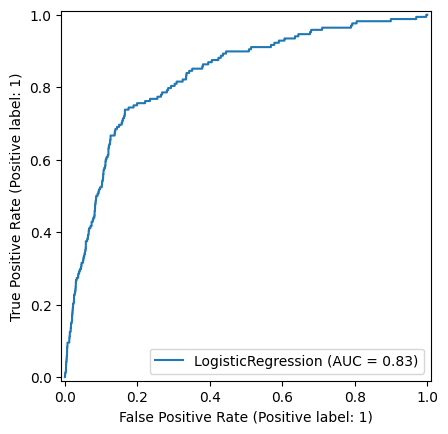

In [170]:
RocCurveDisplay.from_estimator(model1, X_val_preprocessed, y_val)

Text(0.5, 23.52222222222222, 'Predicted label')

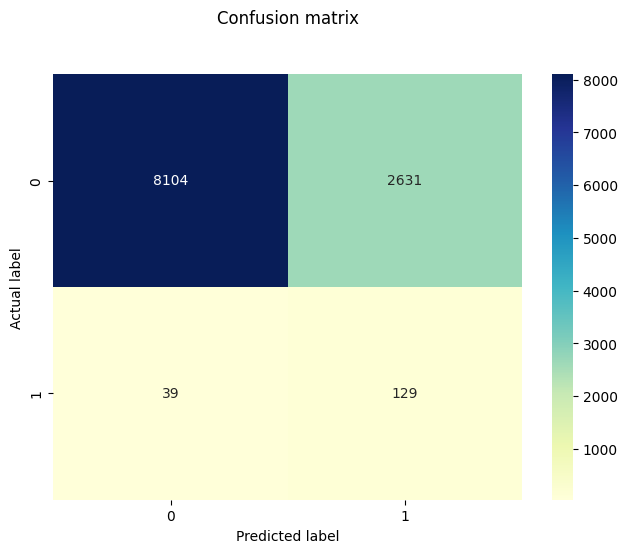

In [171]:
cnf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [172]:
# Model 2 dengan weighted logres
w = {0:1,1:0.9}
model2 = LogisticRegression(class_weight=w,solver='lbfgs', max_iter=1000, random_state=100)

X_smote, y_smote = smote.fit_resample(X_train_preprocessed, y_train)
model2.fit(X_smote,y_smote)
y_pred = model2.predict(X_val_preprocessed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.87     10735
           1       0.05      0.76      0.09       168

    accuracy                           0.78     10903
   macro avg       0.52      0.77      0.48     10903
weighted avg       0.98      0.78      0.86     10903



In [195]:
# Model 3 dengan decision tree
# Min samples split tetap 2 karena banyak fitur bernilai 0 atau 1 saja
# Mengubah min samples leaf tidak memberikan hasil berbeda
tree = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 5,
)
tree.fit(X_smote,y_smote)
y_predict_class = tree.predict(X_val_preprocessed)
print(classification_report(y_val,y_predict_class))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82     10735
           1       0.04      0.83      0.08       168

    accuracy                           0.70     10903
   macro avg       0.52      0.77      0.45     10903
weighted avg       0.98      0.70      0.81     10903



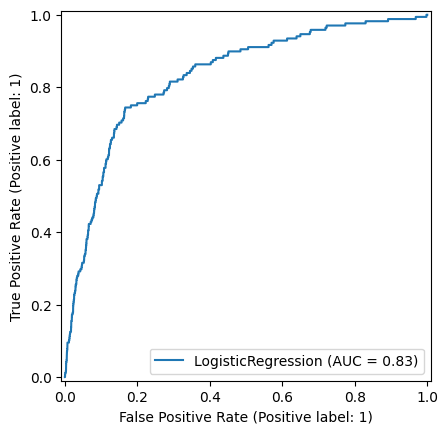

In [173]:
RocCurveDisplay.from_estimator(model2, X_val_preprocessed, y_val)

Text(0.5, 23.52222222222222, 'Predicted label')

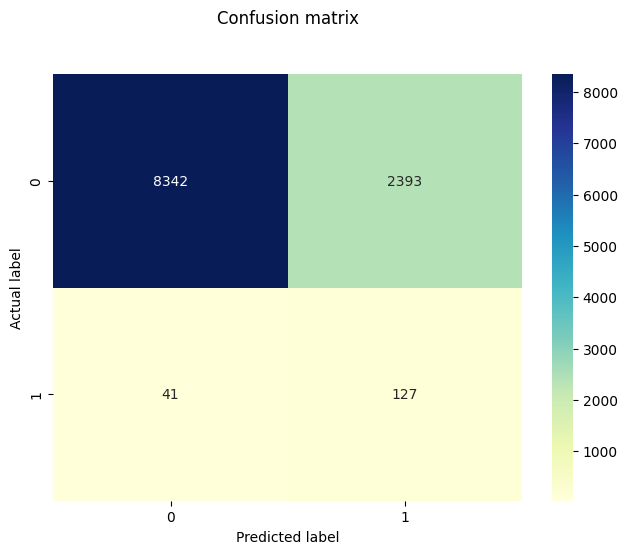

In [174]:
cnf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Model akhir yang dipilih adalah model dengan nilai recall kelas 0 + recall kelas 1 paling besar, yaitu model 2.

## Pickle

In [196]:
import dill as pickle

In [197]:
newdata["Destination"].unique()

array(['singapore', 'malaysia', 'india', 'united states',
       'korea, republic of', 'thailand', 'others', 'japan', 'indonesia',
       'viet nam', 'australia', 'united kingdom', 'hong kong', 'china',
       'taiwan, province of china', 'canada', 'philippines',
       'brunei darussalam', 'myanmar', 'france', 'new zealand',
       'cambodia'], dtype=object)

In [202]:
newdata["Product Name"].unique()

array(['others', 'cancellation plan', 'basic plan',
       '2 way comprehensive plan', 'bronze plan',
       '1 way comprehensive plan', 'rental vehicle excess insurance',
       'value plan'], dtype=object)

In [230]:
def f(test):
    # Preprocessing input data
    newtest = test.drop(["Agency","Gender"],axis='columns')
    for i in newtest.select_dtypes(include=['object']).columns:
        newtest[i] = newtest[i].apply(str.lower)

    dest = ['singapore', 'malaysia', 'india', 'united states',
       'korea, republic of', 'thailand', 'others', 'japan', 'indonesia',
       'viet nam', 'australia', 'united kingdom', 'hong kong', 'china',
       'taiwan, province of china', 'canada', 'philippines',
       'brunei darussalam', 'myanmar', 'france', 'new zealand',
       'cambodia']
    newtest["Destination"] = newtest["Destination"].apply(lambda x: "others" if x not in dest else x)

    productname = ['others', 'cancellation plan', 'basic plan',
       '2 way comprehensive plan', 'bronze plan',
       '1 way comprehensive plan', 'rental vehicle excess insurance',
       'value plan']
    newtest["Product Name"] = newtest["Product Name"].apply(lambda x: "others" if x not in productname else x)

    fitur = ['Agency Type','Distribution Channel','Product Name','Destination','Duration','Net Sales','Commision (in value)','Age']
    clean = transformer.transform(newtest[fitur])
    clean = pd.DataFrame.sparse.from_spmatrix(clean)

    fitur2 = list(transformer.transformers_[0][1].get_feature_names_out()) + ['Duration_scaled', 'Net Sales_scaled', 'Commision (in value)_scaled', 'Age_scaled']
    clean.columns = fitur2
    result = model2.predict(clean)

    return result

In [232]:
testdata = pd.read_csv(r"E:\DS\CAPSTONE3\testt.csv")
yahu = f(testdata)
yahu


array([1, 0])

In [233]:
with open('FinalModel.pkl', 'wb') as file:
    pickle.dump(f, file)